In [1]:
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt

1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [77]:
# Generate a 3D dataset 
N   = 1000

x1 = np.random.normal(0, 1, N)
x2 = x1 + np.random.normal(0, 3, N)
x3 = 2*x1 + x2

M = np.array([x1, x2, x3])

# Find eigenvectors and eigenvalues of the covariance matrix of the dataset
cov_M = np.cov(M)
l, V = la.eig(cov_M)
print("Eigendecomposition")
print(np.real_if_close(l), "\n", V)

# Find eigenvectors and eigenvalues of the covariance matrix of the dataset using SVD, check that results matches
U, spectrum, Vt = la.svd(M)
print("----------------------------------------------------------------------", "\n\n SVD")
print(spectrum**2/(N-1), "\n", U)

print("\n\n Results matches?")
print("Spectrum:\n", np.sort(np.real_if_close(l)), "\n", np.sort(spectrum**2/(N-1)))
print("Eigenvectors:\n", V, "\n", U)


(3, 1000)
Eigendecomposition
[2.7490e+01 1.0079e-15 1.9517e+00] 
 [[-0.1138 -0.8165  0.566 ]
 [-0.5794 -0.4082 -0.7054]
 [-0.807   0.4082  0.4266]]
---------------------------------------------------------------------- 

 SVD
[2.7506e+01 1.9521e+00 1.5453e-31] 
 [[-0.1139  0.566  -0.8165]
 [-0.5794 -0.7055 -0.4082]
 [-0.8071  0.4266  0.4082]]


 Results matches?
Spectrum:
 [1.0079e-15 1.9517e+00 2.7490e+01] 
 [1.5453e-31 1.9521e+00 2.7506e+01]
Eigenvectors:
 [[-0.1138 -0.8165  0.566 ]
 [-0.5794 -0.4082 -0.7054]
 [-0.807   0.4082  0.4266]] 
 [[-0.1139  0.566  -0.8165]
 [-0.5794 -0.7055 -0.4082]
 [-0.8071  0.4266  0.4082]]


Recall that _spectrum_ are the square root of the eigenvalues of $MM^T$, for matching with the covariance matrix we have to notice that, having 0 mean for all features $cov_M = MM^T/(N-1)$. Using this mapping we notice that the resulting eigenvalues are slightly different for the two differents methods, in particular for the smallest one.

About the eigenvectors we look at the columns of $V$ for the eigendecomposition and $U$ for the SVD. Again, values are very similiar but not identical, also one column is switched for $U$ w.r.t $V$.

In [57]:
# What percent of the total dataset's variability is explained by the principal components? 
# Reduce the dimensionality of the system so that at least 99%of the total variability is retained.
Lambda=np.diag(np.real_if_close(l))
print("p=3 => k=1,2")
print ("PCA w k=1 (0):",abs(Lambda[0,0])/Lambda.trace(), "of the total variability conserved")
print ("PCA w k=1 (1):",abs(Lambda[1,1])/Lambda.trace(), "of the total variability conserved")
print ("PCA w k=1 (2):",abs(Lambda[2,2])/Lambda.trace(), "of the total variability conserved")

print ("PCA w k=2 (0,1):",abs(Lambda[0,0]+Lambda[1,1])/Lambda.trace(), "of the total variability conserved")
print ("PCA w k=2 (0,2):",abs(Lambda[0,0]+Lambda[2,2])/Lambda.trace(), "of the total variability conserved")
print ("PCA w k=2 (1,2):",abs(Lambda[1,1]+Lambda[2,2])/Lambda.trace(), "of the total variability conserved")

p=3 => k=1,2
PCA w k=1 (0): 0.9273396025365369 of the total variability conserved
PCA w k=1 (1): 4.1447940095163886e-17 of the total variability conserved
PCA w k=1 (2): 0.07266039746346308 of the total variability conserved
PCA w k=2 (0,1): 0.9273396025365369 of the total variability conserved
PCA w k=2 (0,2): 1.0 of the total variability conserved
PCA w k=2 (1,2): 0.07266039746346302 of the total variability conserved


Given how the dataset was constructed, do these make sense? 
It make sense, the single component that conserves more variability is the first...

(-15.0000, 15.0000)

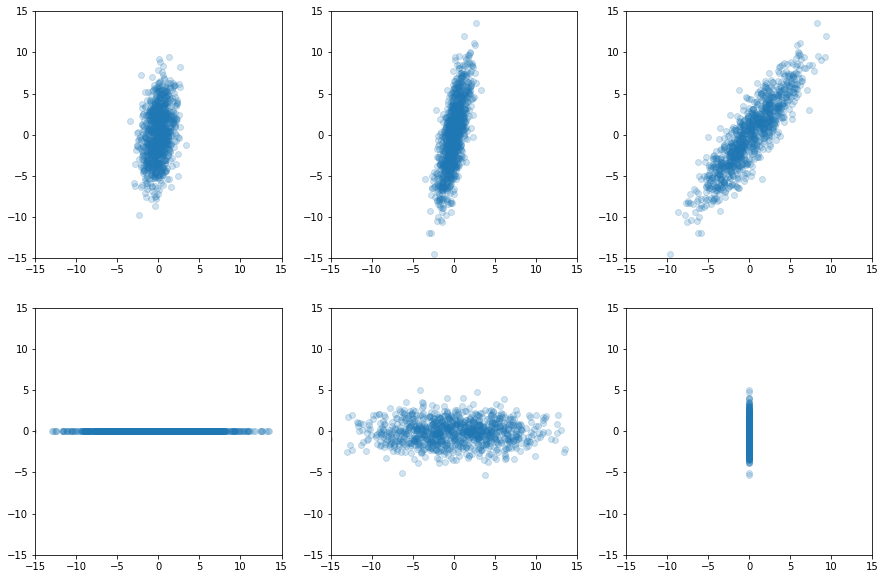

In [71]:
# Redefine the data in the basis yielded by the PCA procedure
M_ = np.dot(V.T, M)

# Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows
# of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

ax1.scatter(M[0, :], M[1, :], alpha=0.2)
ax1.set_xlim([-15,15])
ax1.set_ylim([-15,15])

ax2.scatter(M[0, :], M[2, :], alpha=0.2)
ax2.set_xlim([-15,15])
ax2.set_ylim([-15,15])

ax3.scatter(M[1, :], M[2, :], alpha=0.2)
ax3.set_xlim([-15,15])
ax3.set_ylim([-15,15])

ax4.scatter(M_[0, :], M_[1, :], alpha=0.2)
ax4.set_xlim([-15,15])
ax4.set_ylim([-15,15])

ax5.scatter(M_[0, :], M_[2, :], alpha=0.2)
ax5.set_xlim([-15,15])
ax5.set_ylim([-15,15])

ax6.scatter(M_[1, :], M_[2, :], alpha=0.2)
ax6.set_xlim([-15,15])
ax6.set_ylim([-15,15])


2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [88]:
noise = []
for i in range(10):
    noise.append(np.random.normal(0, 1/50, N))

M_ = np.concatenate((M, np.array(noise)))

cov_M_ = np.cov(M_)
l, V = la.eig(cov_M_)
Lambda=np.diag(np.real_if_close(l))
print(np.real_if_close(l)/np.trace(Lambda))

[ 9.3358e-01  6.6282e-02 -5.0936e-19  1.5927e-05  1.5420e-05  1.1412e-05
  1.1605e-05  1.2248e-05  1.2599e-05  1.3061e-05  1.4277e-05  1.3798e-05
  1.3825e-05]


Again the two principal variables are the same as before, the variability associated to the noise ones is negligible.

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [ ]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 